# Week 4: Image Segmentation
### Date: 26 Oct 2023

Last week you learned about different methods for segmenting an image into regions of interest and coding some algorithms. In this session you will get some more experience coding image segmentation algorithms. Your task will be to code a simple statistical method that uses Region growing or connected components.

In [1]:
import numpy as np
import copy
import cv2
# to visualize the plots within the notebook
%matplotlib inline
# to enable interactive
#%matplotlib ipympl
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import random
from PIL import Image

## Task 1: Region growing
Region growing is a simple way to segment a region of interest from the background of an image.
It takes in a gray-scale image and produces a binary image as output, where a value of 1 represents the region of interest and a value of 0 represents the background.

The algorithm is:
1. Start from a seed pixel.
2. Add neighbouring pixels that satisfy the criteria defining a region (e.g. similar intensity values, intensity above a threshold).
3. Repeat until we can include no more pixels.

Your task is to write a function in Python that implements the region growing algorithm.
Something like:
```
  segmented_img = region_growing(img, x, y)
```

* img: the image to be segmented
* x: the x-coordinate (j if indexed by numpy array) of the seed pixel
* y: the y-coordinate (i if indexed by numpy array) of the seed pixel
* segmented_img: the binary image output of region growing

**Hint:** This is process basically a **Breadth-first Search (BFS)**, which could be easily implemented it with a **queue** (check out collections.deque in PyThon): 

1. Initialise the queue with the seed pixel. 
2. Every time pop the first element from the queue and add its neighbour pixels to the queue if they satisfy the criteria (e.g. intensity above the threshold).
3. Finish when the queue is empty

In the slide 36 in the lecture slides, you were given a slightly different implementation, where all the neighboring pixels are added to the queue and the check is done when the element is popped from the queue. Think about the difference between these two implementations.

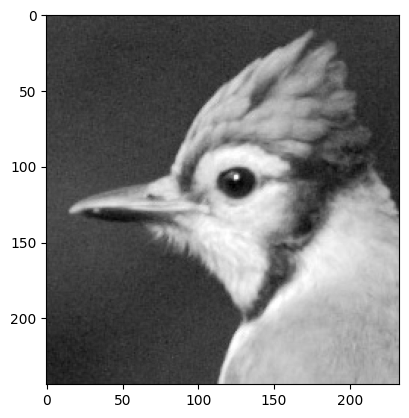

In [2]:
# Load your image
img = cv2.imread('../images/sample_image.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
plt.imshow(gray_img, 'gray')
plt.show()

**Algorithm: Region Growing**

**Input:**  
- `img`: gray-scale image of size $(H \times W$  
- $(x, y)$: seed pixel coordinates  
- `thresh`: threshold for region inclusion  
- `connectedness`: 4 or 8 connected neighbors

**Steps:**

1. **Initialize:**  
   - Mark the seed pixel as visited.  
   - Add the seed pixel to the boundary queue.

2. **While the boundary queue is not empty:**  
   - Dequeue the next point from the boundary.  
   - If the point satisfies the threshold, mark it as part of the region.  
   - For each neighbor of the point:  
     - If the neighbor is within bounds and unvisited, mark it as visited and enqueue it.

3. **Repeat until the boundary queue is empty.**


In [57]:
from collections import deque
def region_growing(img, x, y, thresh=100, connectedness=4):
    '''
    Impelemnt region growing algorithm to segment a gray scaled image into regions
    :param img: gray scaled image [H, W]
    :param x, y: coordinate of the seed pixel
    :param thresh: region growing threshold
    :return: segmented image [H, W]
    '''
    assert img.ndim == 2, "Expect a gray-scale image!!!"
    # Write your own code here

    # Initalize region result map
    bin_img = np.zeros(img.shape)
    # Could set a lower bound here, which will slide the thresholding domain down the inital pixel value according to the lower bound
    lower_bound = 0
    # Compute minimum and maximum intensities with threshold bounds
    min_thr, max_thr = img[x,y] - lower_bound, img[x,y] + thresh - lower_bound
 
    # Runs probably faster if selection is constant and not runtime computed in the function 
    # This List does not trigger a clockwise neighbourhood queue - but seems to be not an issue
    neighbour_filter = {    
        4 : np.array([
            [0,1],
            [-1,0],[0,1],
            [0,-1]
        ]),
        8 : np.array([
            [-1,1],[0,1],[1,1],
            [-1,0],[1,0],
            [-1,-1],[0,-1],[1,-1]
        ])
    }
    # Return neighbours no implemented 
    def add_neighbours(pixel, neighbours):
        new_neighbours = []
        pixel_neighbours = neighbours + pixel
        for n in pixel_neighbours:
                current_x = n[0]
                current_y = n[1]
                # Edge index handeling
                if current_x < 0 or current_y < 0 or current_x > img.shape[0]-1 or current_y > img.shape[1]-1 :
                    continue
                # Check if neighbour is within range, append queu and set in region map as in range
                if img[current_x, current_y] >= min_thr and img[current_x, current_y] < max_thr and bin_img[current_x, current_y] < 1.0 :
                    bin_img[current_x, current_y] = 1.0
                    new_neighbours.append([current_x, current_y])
                # If neighbour is NOT within range mark as visited (2.0) to not be pulled again and speed up
                elif bin_img[current_x, current_y] < 1.0:
                    bin_img[current_x, current_y] = -1.0
        return new_neighbours

    # Initalize queue with the seed pixel and add all neighbours.
    seed_pixel = np.array([x,y])
    bin_img[seed_pixel[0], seed_pixel[1]] = 1.0
    queue = [seed_pixel]

    # Start checking for pixel in queue if they are fitting cirteria and if yes add to queue the new neighbours unless not in range 
    while len(queue) > 0:
        for n in add_neighbours(queue.pop(), neighbour_filter[connectedness]):
            queue.append(n)

    # Release binary region results - Without the clipping the region edge would be drawn in a separate color
    return np.clip(bin_img, 0, 1)
    

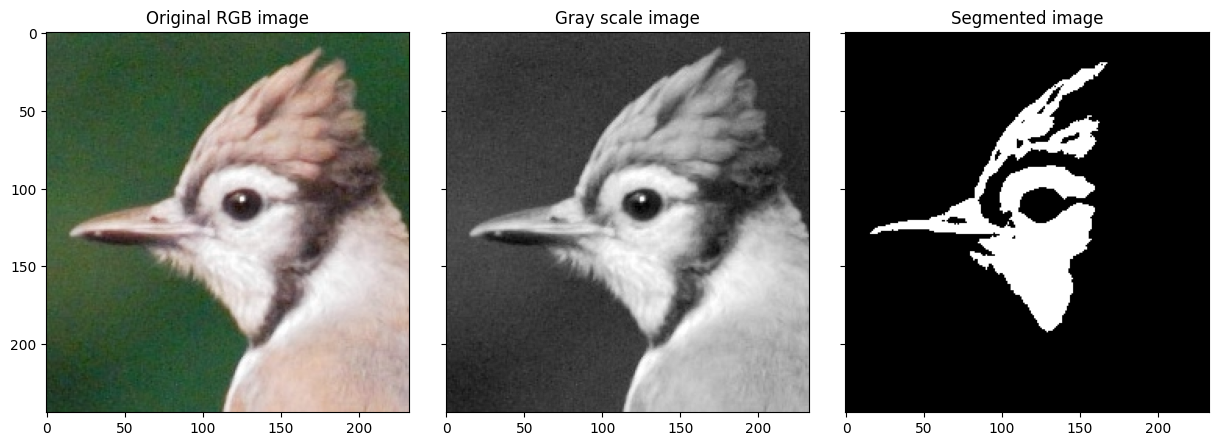

In [58]:
# define set of seed pixel points
x, y = 100, 100

# run region growing algorithm
seg_img = region_growing(gray_img, x, y, thresh=100, connectedness=8)

# Show Original and segmented image
fig, axis = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(img)
axis[0].set_title('Original RGB image')

axis[1].imshow(gray_img, 'gray')
axis[1].set_title('Gray scale image')

axis[2].imshow(seg_img, 'gray')
axis[2].set_title('Segmented image')

plt.show()

### There are two important factors that influence the performance of a region growing algorithm.

#### 1. The first is the seed pixel selection.
Try the following:
1. Pick a random pixel in the image.
2. Plot the histogram of the image, select a reasonable threshold and then search for a pixel whose intensity value is above the threshold (look for the `matplotlib.pyplot.hist()` function).
3. Do it manually (Hint: You can do this by enabling the interactive mode for `matplotlib`).

Which one is better?

In [5]:
import ipywidgets 

In [ ]:
# I guess with this plot we just show the potential pixel that could be part of the grown region,
# yet we dont know if all of them are actually connected as a region

def plot_hist_interactive(threshold = 100, X = 0.5, Y =0.5):
    # Pick select pixel color and ensure pixel number never out of bounds
    baseline_color = gray_img[int(gray_img.shape[0]*X), int(gray_img.shape[1]*Y)]
    # COmpute upper bound 
    max_v = baseline_color + threshold
    # Select only values that are within bound
    thresholded_img = gray_img[(gray_img > baseline_color) & (gray_img < max_v)]
    # Plot selected histogram
    plt.hist(thresholded_img, bins=255, range=(0, 255))
    plt.ylim(0,1750)

# Add interactive chart
ipywidgets.interact(plot_hist_interactive, threshold = (0,255,1), X = (0,1,0.001), Y =(0,1,0.001))


interactive(children=(IntSlider(value=100, description='threshold', max=255), FloatSlider(value=0.5, descripti…

<function __main__.plot_hist_interactive(threshold=100, X=0.5, Y=0.5)>

#### 2. The second important factor is how to decide whether to add a neighbouring pixel to the existing region. 

Again, there are different options. Try the following alternatives:

1. Compare the pixel intensity value of the neighbours to a specified threshold (try the pixel intensity value of the initial seed pixel). If it is larger, then add it to the region. Depending on the seed pixel you might consider adding pixels with smaller intensities or even using a range of valid intensity values.
    
2. Compare the pixel intensity value of the neighbours to the average pixel intensity value of the existing region. How will we decide when to add neighbours to the region in this case?

Which one is better?

In [ ]:
# Write your own code here

# Not really sure if I understand the questions here


### More things to try out:
1. What kind of connectivity did you use for considering neighbour pixels? If you used 4- connectivity, try 8-connectivity, if you used 8-connectivity then try 4-connectivity.
    Does this change results?
    
2. What if there are multiple regions of interest? Consider using multiple seed points. How will you choose these?

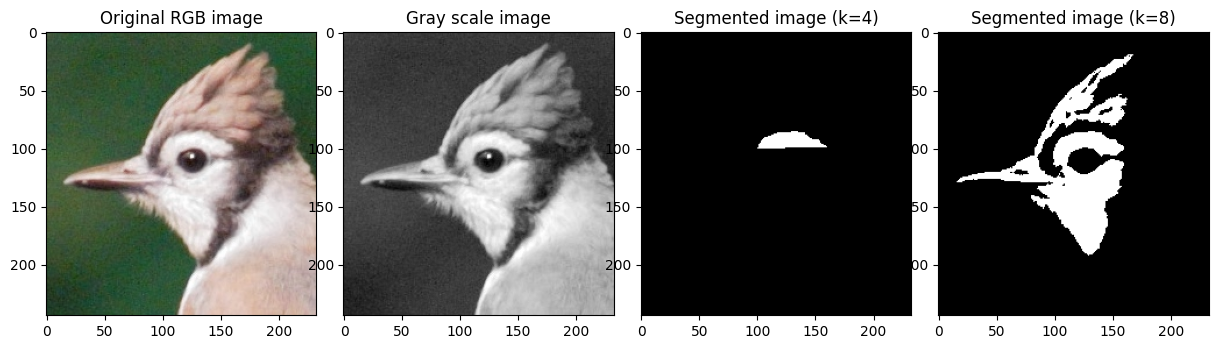

In [62]:
# define set of seed pixel points
x, y = 100, 100

# run region growing algorithm
seg_img = region_growing(gray_img, x, y, thresh=100, connectedness=4)
seg_img2 = region_growing(gray_img, x, y, thresh=100, connectedness=8)

# Show Original and segmented image
fig, axis = plt.subplots(1, 4, figsize=(15,15))
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(img)
axis[0].set_title('Original RGB image')

axis[1].imshow(gray_img, 'gray')
axis[1].set_title('Gray scale image')

axis[2].imshow(seg_img, 'gray')
axis[2].set_title('Segmented image (k=4)')

axis[3].imshow(seg_img2, 'gray')
axis[3].set_title('Segmented image (k=8)')
plt.show()

## Task 2: Connected Components 

Connected-component labeling (also known as connected-component analysis, or region labeling) is an algorithmic application of graph theory that is used to determine the connectivity of “blob”-like regions in a binary image.
Specifically, the algorithm labels each connected component of a binary image with a separate number.

Similar to Region Growing, for a single connected-component we can start from a seed and iteratively traverse all the neighbouring pixels. In this case,you can perform Depth-first Serach (DFS). Then we just need to repeat this process for all the connected components in the image.

In [ ]:
# I am a bit confused with this version of connected components. Usually we dont know the number of 
# components in an image and that is what the algorithm is supposed to determine. Meaning I have to 
# traverse through the entire Image row by row and label the image based on components. And on top of this
# I maintain a list of "connected components" so that I can updated thos labels according to their connectedness
# 
# I dont understand how I would traverse from a random seed and a 4-neighboured to label the entire image correctly and
# actually count the the connected components. 

# Store constant for neighbour selection - N and W
neighbour_filter = {    
    4 : np.array([
        [-1,0],[0,-1]
    ])
}

def connected_components_label(img, connectedness=4):
    # Iniatlize label data and component count
    labels = np.zeros_like(img)
    c_label = 1
    connected_map = {}
    
    # Loop through image rows
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            # If binary mask active
            if img[x,y] > 0:
                # Check only valid neighbours depending on edge sitution of pixel
                # Edge handeling
                ns_filter = []
                if x > 0 and y > 0:
                    ns_filter = neighbour_filter[connectedness]
                elif x == 0 and y == img.shape[1]-1:
                    labels[x,y] = c_label
                    continue
                elif x == 0:
                    ns_filter = np.array([neighbour_filter[connectedness][1]])
                elif y == 0:
                    ns_filter = np.array([neighbour_filter[connectedness][0]])

                # Retrieve current neighbours
                # not very elegant but somehow I did not get it to work an easier way
                pixel = np.array([x,y])
                ns_coord = (ns_filter + pixel)
                neighbours_label = []
                for i in range(ns_coord.shape[0]):
                    neighbours_label.append(labels[ns_coord[i,0],ns_coord[i,1]])
                neighbours_label = np.array(neighbours_label)
                connected_min_label = None
                if any(neighbours_label > 0):
                    neighbours_label = np.sort(neighbours_label[neighbours_label > 0])
                    connected_min_label = neighbours_label[0]

                # Assign label and increase component count label if needed
                if connected_min_label != None:
                    labels[x,y] = connected_min_label
                    # Update connected map to merge components that are connected but due to 
                    # column-by-column traverse initally assigned different values
                    if len(neighbours_label) == 2:
                        # Deal with nested connected components
                        # Use same connected map label if connected to child component and not root component
                        # This is essential for merging the the "connected components" correctlt in the second iteration
                        if neighbours_label[0] in connected_map:
                            connected_map[neighbours_label[1]] = connected_map[neighbours_label[0]]
                        # If connected component which is directly connected with root component
                        else:
                            connected_map[neighbours_label[1]] = neighbours_label[0]
                else:
                    labels[x,y] = c_label
                    c_label += 1

    # Update based on connected components and merge connected regions
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if labels[i,j] in connected_map:
                labels[i,j] = connected_map[labels[i,j]]

    return labels


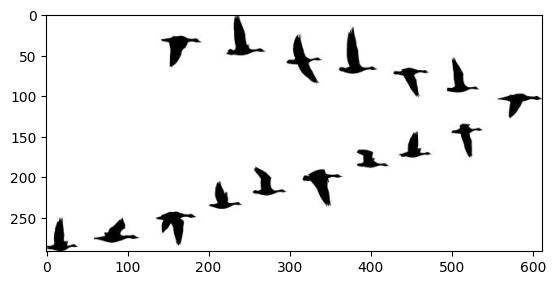

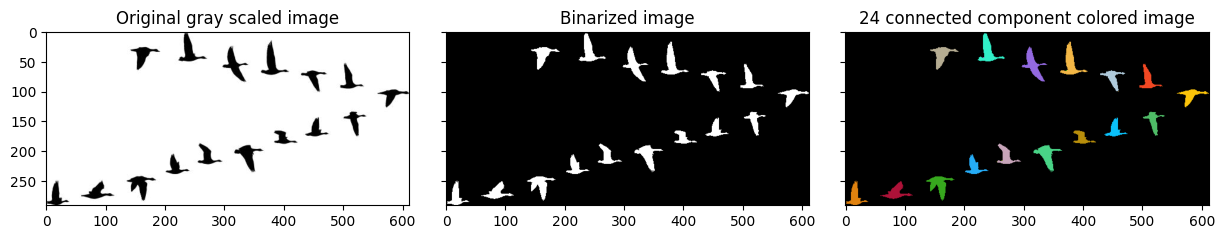

In [ ]:
from utils import colourize

img2 = cv2.imread("../images/gooses.jpg")
gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY).astype(np.float32)
plt.imshow(gray_img2, 'gray')

bimg2 = (gray_img2 < 100).astype(np.float32)
ccl_img2 = connected_components_label(bimg2)

fig, axis = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(gray_img2, 'gray')
axis[0].set_title('Original gray scaled image') 

axis[1].imshow(bimg2, 'gray')
axis[1].set_title('Binarized image')

axis[2].imshow(colourize(ccl_img2))
# Seems like it creates more connected components than expected. Small artifacts? Almost not visible but yet something seems fishy.
axis[2].set_title(f'{len(np.unique(ccl_img2))} connected component colored image')
plt.show()

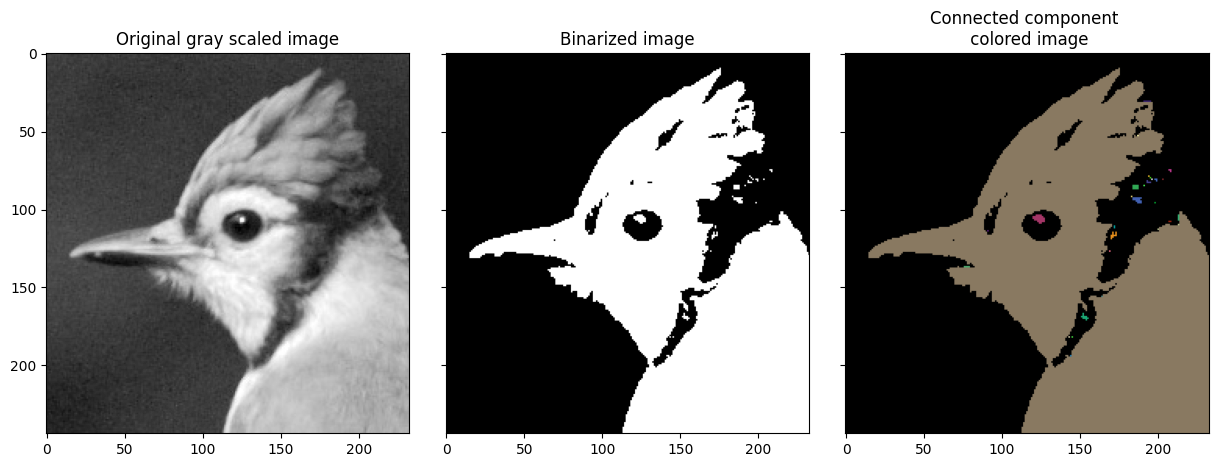

In [195]:
bimg = (gray_img > 100).astype(np.float32)
ccl_img = connected_components_label(bimg)

fig, axis = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(gray_img, 'gray')
axis[0].set_title('Original gray scaled image')

axis[1].imshow(bimg, 'gray')
axis[1].set_title('Binarized image')

axis[2].imshow(colourize(ccl_img))
axis[2].set_title('Connected component \n colored image')
plt.show()